In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
from astroduet.duet_sensitivity import calc_exposure
import numpy as np
from matplotlib import pyplot as plt
from astroduet.bbmag import bb_abmag_fluence, bb_abmag
from astroduet.utils import get_neff

import astroduet.config as config
from astroduet.utils import get_neff
from astroduet.background import background_pixel_rate


from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
duet = config.Telescope(config='minimum_mass')
duet.config_list

['baseline',
 'classic',
 'minimum_mass',
 'fine_plate',
 'equal_mass',
 'largest_aperture',
 'reduced_baseline']

classic
minimum_mass
fine_plate
equal_mass
largest_aperture
reduced_baseline


/Users/bwgref/anaconda/envs/duet/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


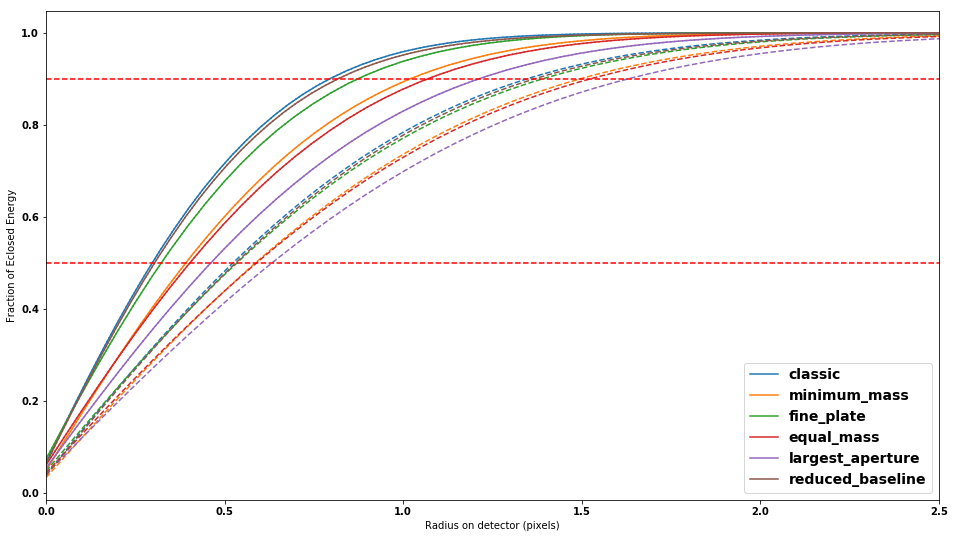

In [5]:
f = plt.figure(figsize=[16, 9])
for ind, tel_type in enumerate(duet.config_list):
    if ind == 0:
        continue
    print(tel_type)
    duet = config.Telescope(config=tel_type)
    duet.diq_rms = 1.*u.micron
    pix, radpro = duet.calc_radial_profile()
    rind = np.arange(0,len(radpro))*pix / duet.pixel
    eef = np.cumsum(radpro)
    line, = plt.plot(rind, eef /eef.max(), label=duet.config)
    plt.xlim([0, 4])
    
    
    pix, radpro = duet.calc_radial_profile()
    rind = np.arange(0,len(radpro))*pix / duet.pixel
    eef = np.cumsum(radpro)
    plt.plot(rind, eef /eef.max(), color = line.get_color(), linestyle = ':')


    # Now with jitter:
    duet = config.Telescope(config=tel_type)
    pix, radpro = duet.calc_radial_profile()
    rind = np.arange(0,len(radpro))*pix / duet.pixel
    eef = np.cumsum(radpro)
    plt.plot(rind, eef /eef.max(), color = line.get_color(), linestyle = '--')

plt.xlim([0, 2.5])
plt.legend(fontsize=14)
plt.axhline(y=0.5, linestyle = '--', color ='r')
plt.axhline(y=0.9, linestyle = '--', color ='r')

plt.xlabel('Radius on detector (pixels)')
plt.ylabel('Fraction of Eclosed Energy')

plt.savefig('EEF_comparison.png')

In [11]:
# FOM: Time to 22 ABmag for this configuration for DUET1
# Old FOM for this 

siglimit=10
swiftmag = 21
dmag = 0.05
bbmag1 = 5*u.ABmag
bbmag_target = 22*u.ABmag

duet = config.Telescope(config='classic')
bandone = duet.bandpass1
bandtwo = duet.bandpass2
while bbmag1 < bbmag_target:
    swiftmag+=dmag
    bbmag1, bbmag2 = bb_abmag(swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K, bandone = bandone, bandtwo=bandtwo)
print(f"""-----
        Swift AB mag {swiftmag}
        DUET1 AB mag {bbmag1}
        DUET2 AB mag {bbmag2}""")



for ind, tel_type in enumerate(duet.config_list):


    print()
    duet = config.Telescope(config=tel_type)
    duet.info()
    
#    duet.psf_fwhm = duet.calc_psf_fwhm()
#    duet.neff = get_neff(duet.psf_fwhm, duet.pixel)

    siglimit=10
    bandone = duet.bandpass1
    bandtwo = duet.bandpass2

#     # Low Zodi, 10-sigma case
#     [bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi=True)
#     band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
#     band1_rate = duet.fluence_to_rate(band1_fluence)
#     req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#    print('Low-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    
#     [bgd_band1, bgd_band2] = background_pixel_rate(duet, med_zodi=True)
#     band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
#     band1_rate = duet.fluence_to_rate(band1_fluence)
#     req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#     print('Med-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
#     print('Med-Zodi {}-sig, {} FoM min'.format(siglimit, 2*req_exp.value/60.))
#     print('Med-Zodi {}-sig, {} 300-s frames'.format(siglimit, 2*req_exp.value/300.))

    # High Zodi, 10-sigma case.
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#    print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))

    print(f"""-----
        Config: {duet.config}
        Frame Duration: {req_exp.value}
        FOM (minutes to survey error box): {2*req_exp.value/60.}
    """)
#    print('High-Zodi {}-sig, {} FoM min'.format(siglimit, 2*req_exp.value/60.))


#     # High Zodi, 5-sigma case
#     siglimit=10
#     [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
#     band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
#     band1_rate = duet.fluence_to_rate(band1_fluence)

#     req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#     print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    



-----
        Swift AB mag 22.000000000000014
        DUET1 AB mag 22.000470091092396 mag(AB)
        DUET2 AB mag 21.58825736350795 mag(AB)

-----
        DUET Telescope State: baseline
        Physical Entrance Pupil: 26.0 cm
        Effective EPD: 24.2 cm
        Effective Area: 459.9605804120816 cm2
        Transmission Efficiency: 0.8166518036622619
        
        Pixel size: 6.4 arcsec
        Pointing RMS: 2.5 arcsec
        DIQ RMS: 4.406714876186114 arcsec
        Effective PSF FWHM: 12.5 arcsec
        N_eff: 9.75310538172716

        Band 1: {'eff_wave': <Quantity 202.56878682 nm>, 'eff_width': <Quantity 53.32814342 nm>}
        Bandpass 1: [175.90471511 229.23285853] nm
        Band 2: {'eff_wave': <Quantity 281.7531854 nm>, 'eff_width': <Quantity 68.16239088 nm>}
        Bandpass 2: [247.67198996 315.83438085] nm

        Dark current: 0.0115 ph / s
        Read noise (RMS per read): 7
        -----
        
-----
        Config: baseline
        Frame Duration: 2318.626